../src/calibrate.py:95: RuntimeWarning: invalid value encountered in true_divide
  resid_values = np.divide(greedy_distr, mass)
../src/calibrate.py:95: RuntimeWarning: invalid value encountered in true_divide
  resid_values = np.divide(greedy_distr, mass)
../src/calibrate.py:95: RuntimeWarning: invalid value encountered in true_divide
  resid_values = np.divide(greedy_distr, mass)
../src/calibrate.py:95: RuntimeWarning: invalid value encountered in true_divide
  resid_values = np.divide(greedy_distr, mass)
../src/calibrate.py:95: RuntimeWarning: invalid value encountered in true_divide
  resid_values = np.divide(greedy_distr, mass)
../src/calibrate.py:95: RuntimeWarning: invalid value encountered in true_divide
  resid_values = np.divide(greedy_distr, mass)
../src/calibrate.py:95: RuntimeWarning: invalid value encountered in true_divide
  resid_values = np.divide(greedy_distr, mass)
../src/calibrate.py:95: RuntimeWarning: invalid value encountered in true_divide
  resid_values = np.div

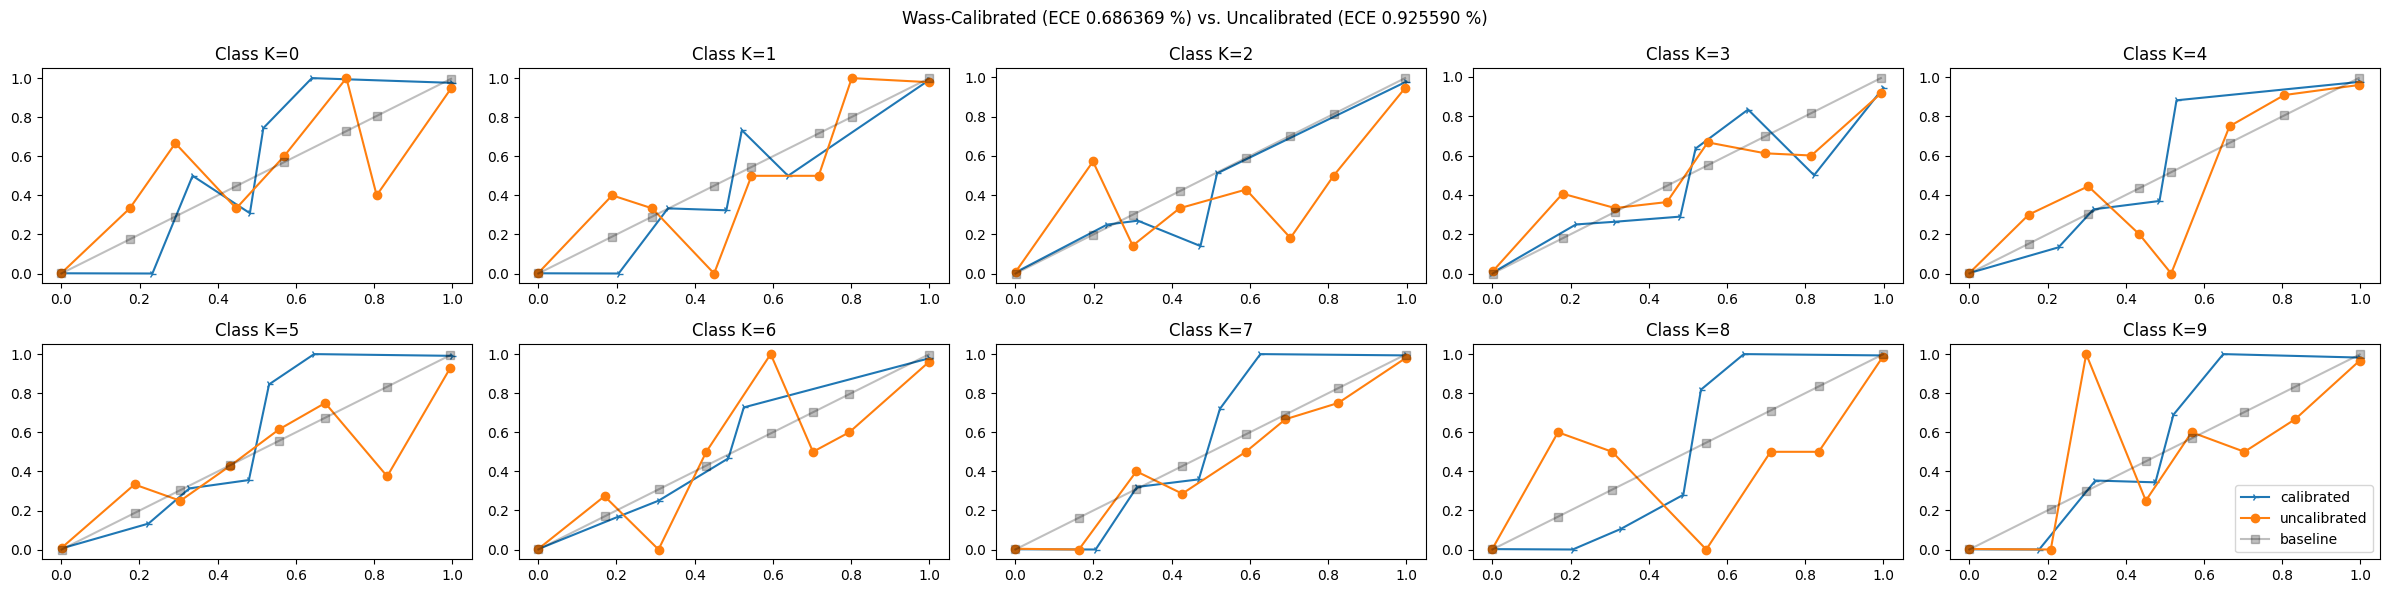

In [127]:
import sys
sys.path.append('../src/')
sys.path.append('../data/')


import numpy as np
from calibrate import *
from read_logits import *
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


#Load data from CIFAR
cifar10 = Loader("CIFAR10")
simplex, labels = cifar10.simplex, cifar10.labels

#Hyperparameters

#for approximating distributions probabilities (Pr[Pk])
n_bins = 1000
bins = np.linspace(0,1,n_bins+1)

#for visualizing reliability diagrams
n_conf = 8

#train test split param
split_p = 0.5

#Set length of dataset
N = len(simplex)
train_N = int(N*split_p)
test_N = N - train_N

#Number of classes
K = simplex.shape[1]

X_train, X_test, y_train, y_test = train_test_split(
    simplex,
    labels,
    shuffle=False,
    test_size=test_N,
)

y_train_pred = np.argmax(X_train, axis=1)
y_test_pred = np.argmax(X_test, axis=1)


# Place to collect scores before normlizing them
collect = []
for k in range(K):

    num_k = (y_train == k).sum() 
    Xk_train, yk_train = X_train[y_train == k], np.ones(num_k)
    Xnotk_train, ynotk_train = X_train[y_train != k][:num_k], np.zeros(num_k)

    Xk_train = np.vstack([Xk_train, Xnotk_train])
    Yk_train = np.hstack([yk_train, ynotk_train])   
    
    binaryCLF = RandomForestClassifier()
    binaryCLF.fit(Xk_train, Yk_train)
    class_k = binaryCLF.predict(X_test).astype(int)
    yk_true = (y_test == k).astype(int)
    yk_pred = X_test[:, k]
    bin_pred = snap(yk_pred, bins=bins).reshape(-1, 1)


    transported = bin_pred.copy()
        
    for kk in range(2):
        k_plan = getTransortPlanK(scores=bin_pred, y=class_k, k=kk, bins=bins)
        transported = applyTransportPlan(a=transported, M=k_plan, y=class_k, k=kk, bins=bins)
    

    collect.append(transported)
    


collected = np.hstack(collect)
collected = np.divide(collected, collected.sum(axis=1).reshape(-1,1))


fig, ax = plt.subplots(2,int(K/2),figsize=(24,6))
for k in range(K):
    i = int(k/int(K/2))
    j = k % int(K/2)
    yk_true = (y_test == k).astype(int)
    yk_pred = X_test[:, k]

    acc, conf = calibration_curve(yk_true, collected[:,k], n_bins=n_conf)
    ax[i,j].plot(conf, acc, marker="4", label="calibrated")

    acc, conf = calibration_curve(yk_true, yk_pred, n_bins=n_conf)
    ax[i,j].plot(conf, acc, marker="o", label="uncalibrated")

    ax[i,j].plot(conf, conf, marker="s", color="black", alpha=0.25, label="baseline")
    ax[i,j].set_title("Class K=%d" % k)
ax[-1,-1].legend()
fig.suptitle("Wass-Calibrated (ECE %f %%) vs. Uncalibrated (ECE %f %%)" % (ECE(y_true = y_test, probs=collected)*100, ECE(y_true = y_test, probs=X_test)*100))
plt.rcParams["figure.autolayout"] = True
plt.show()